In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from IPython import display
%matplotlib inline

In [0]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [0]:
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

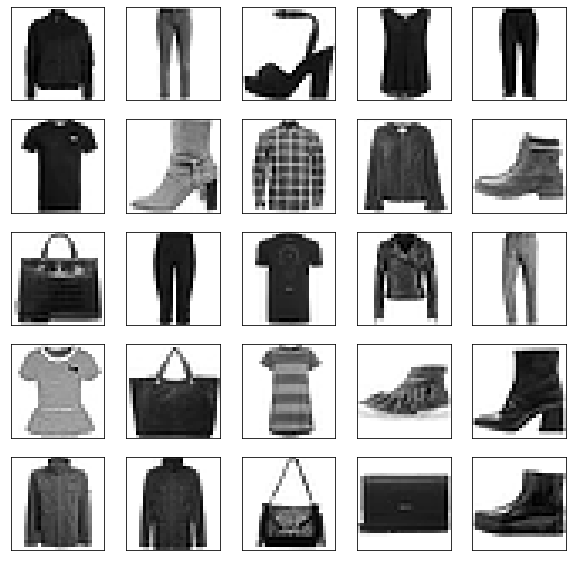

In [0]:
fig, a = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
  for j in range(5):
    a[i][j].imshow(random.choice (x_train), cmap='binary')
    a[i][j].set_xticks([])
    a[i][j].set_yticks([])
plt.show()

In [0]:
# Generator Model
num_features = 100
generator = keras.models.Sequential([
                        keras.layers.Dense(7 * 7 * 256, input_shape=[num_features]),
                        keras.layers.Reshape([7, 7, 256]),
                        keras.layers.BatchNormalization(),
                        keras.layers.Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='selu'),
                        keras.layers.BatchNormalization(),
                        keras.layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='selu'),
                        keras.layers.BatchNormalization(),
                        keras.layers.Conv2DTranspose(filters=1, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='tanh')
])

In [0]:
noise = tf.random.normal(shape=[1, num_features])
generated_images = generator(noise, training=False)

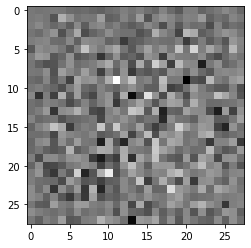

In [0]:
noise = tf.random.normal(shape=[1, num_features])
generated_image = generator(noise)
plt.imshow(np.array(generated_image[0]).reshape(28, 28), cmap='binary')

In [0]:
discriminator = keras.models.Sequential([
                            keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
                            keras.layers.LeakyReLU(0.2),
                            keras.layers.Dropout(0.3),
                            keras.layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same'),
                            keras.layers.LeakyReLU(0.2),
                            keras.layers.Dropout(0.3),
                            keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same'),
                            keras.layers.LeakyReLU(0.2),
                            keras.layers.Dropout(0.3),
                            keras.layers.Flatten(),
                            keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan = keras.models.Sequential([
                  generator,
                  discriminator
])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [0]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  test_input.shape
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
batch_size = 32
seed = tf.random.normal(shape=[batch_size, num_features])
def train_dcgan(gan, dataset, batch_size, num_features, epochs=15):
  generator, discriminator = gan.layers
  for epoch in tqdm(range(epochs)):
    print("Epoch: " + str(epoch))
    for X_batch in dataset:
      noise = tf.random.normal(shape=[batch_size, num_features])
      generated_images = generator(noise)
      X_all = tf.concat([generated_images, X_batch], axis=0)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_all, y1)
      noise = tf.random.normal(shape=[batch_size, num_features])
      y2 = tf.constant([[1.]] * batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [0]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size=batch_size, drop_remainder=True).prefetch(1)

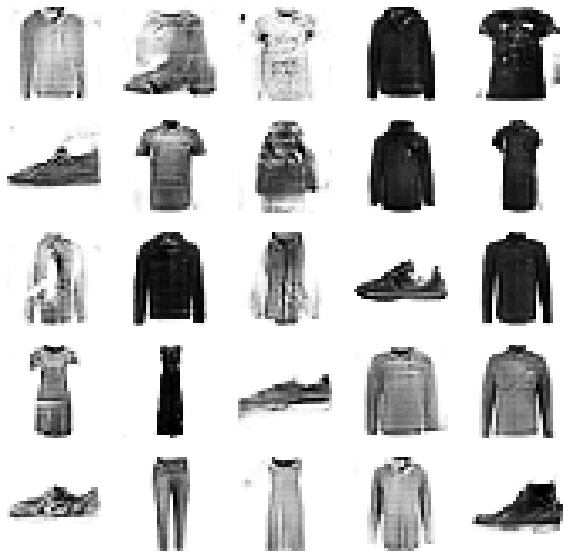

CPU times: user 13min 3s, sys: 45.4 s, total: 13min 49s
Wall time: 17min 34s


In [0]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=20)

In [0]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
display.Image(open(anim_file, 'rb').read())